In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import data_loader
import pymc as pm
import arviz as az

In [3]:
df = data_loader.load_data()

X_cols = df.columns[1:-1]
y_col = df.columns[-1]

In [42]:
df

avg_income  avg_prop_tax  \
statefip Date                                      
Alabama  2000-01-31   41917.384970    271.925118   
         2000-02-29   41917.384970    271.925118   
         2000-03-31   41917.384970    271.925118   
         2000-04-30   41917.384970    271.925118   
         2000-05-31   41917.384970    271.925118   
...                            ...           ...   
Wyoming  2024-09-30  104455.891107      0.000000   
         2024-10-31  104455.891107      0.000000   
         2024-11-30  104455.891107      0.000000   
         2024-12-31  104455.891107      0.000000   
         2025-01-31  104455.891107      0.000000   

                     proportion_American Indian/Aleut/Eskimo  \
statefip Date                                                  
Alabama  2000-01-31                                 0.000000   
         2000-02-29                                 0.000000   
         2000-03-31                                 0.000000   
         2000-04-30                                 0.000000   
         2000-05-31                                 0.000000   
...                                                      ...   
Wyoming  2024-09-30                                 0.008195   
         2024-10-31                                 0.008195   
         2024-11-30                                 0.008195   
         2024-12-31                                 0.008195   
         2025-01-31                                 0.008195   

                     proportion_Asian only  proportion_Black  \
statefip Date                                                  
Alabama  2000-01-31               0.000000          0.262985   
         2000-02-29               0.000000          0.262985   
         2000-03-31               0.000000          0.262985   
         2000-04-30               0.000000          0.262985   
         2000-05-31               0.000000          0.262985   
...                                    ...               ...   
Wyoming  2024-09-30               0.007245          0.007625   
         2024-10-31               0.007245          0.007625   
         2024-11-30               0.007245          0.007625   
         2024-12-31               0.007245          0.007625   
         2025-01-31               0.007245          0.007625   

                     proportion_White  total_population  Median Home Price  
statefip Date                                                               
Alabama  2000-01-31          0.737015         706842.48       97080.984792  
         2000-02-29          0.737015         706842.48       97250.037728  
         2000-03-31          0.737015         706842.48       97363.306485  
         2000-04-30          0.737015         706842.48       97617.062414  
         2000-05-31          0.737015         706842.48       97900.085921  
...                               ...               ...                ...  
Wyoming  2024-09-30          0.961807          67792.43      341148.869753  
         2024-10-31          0.961807          67792.43      343849.922709  
         2024-11-30          0.961807          67792.43      346044.040121  
         2024-12-31          0.961807          67792.43      348280.758951  
         2025-01-31          0.961807          67792.43      350224.417540  

[15351 rows x 8 columns]

In [29]:
state_list = df.reset_index()['statefip'].unique()
state_code = {state: i for i, state in enumerate(state_list)}

states = df.reset_index()['statefip'].apply(lambda x: state_code[x]).values
states

array([ 0,  0,  0, ..., 50, 50, 50])

In [45]:
coords = {'state_idx': state_list}

with pm.Model(coords=coords) as model:

    state_idx = pm.MutableData('state', states, dims='obs_id')

    mu_s = pm.Normal('mu_s', mu=12, sigma=4)
    sigma_s = pm.HalfCauchy('sigma_s', beta=2)

    # Random intercept
    const_prior = pm.Normal('const_prior', mu=mu_s, sigma=sigma_s, dims='state_idx')

    # Random slopes
    tax_slope = pm.Normal('tax_slope', mu=0, sigma=1)
    native_slope = pm.Normal('native_slope', mu=0, sigma=5)
    asian_slope = pm.Normal('asian_slope', mu=5, sigma=2)
    black_slope = pm.Normal('black_slope', mu=0, sigma=1)
    white_slope = pm.Normal('white_slope', mu=0, sigma=1)
    population_slope = pm.Normal('population_slope', mu=0, sigma=1)

    # Model
    y_hat = const_prior[state_idx] + tax_slope * df[X_cols[0]] + native_slope * df[X_cols[1]] + asian_slope * df[X_cols[2]] + black_slope * df[X_cols[3]] + white_slope * df[X_cols[4]] + population_slope * df[X_cols[5]]

    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=100, observed=df[y_col], dims='obs_id')

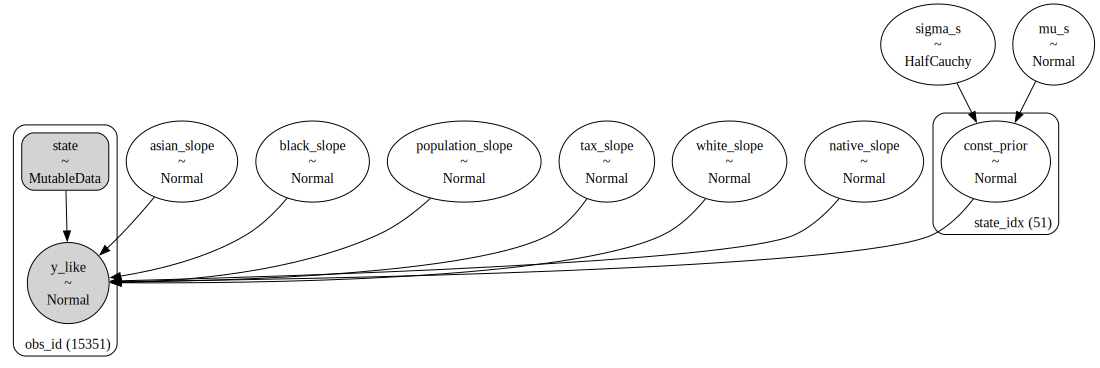

In [46]:
pm.model_to_graphviz(model)

In [47]:
with model:
    trace = pm.sample(2000, tune=2000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_s, sigma_s, const_prior, tax_slope, native_slope, asian_slope, black_slope, white_slope, population_slope]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 256 seconds.
/opt/homebrew/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 7704 divergences after tuning. Increase `target_accept` or repar

/opt/homebrew/lib/python3.10/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (59), generating only 20 plots
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/homebrew/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/homebrew/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/homebrew/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: 

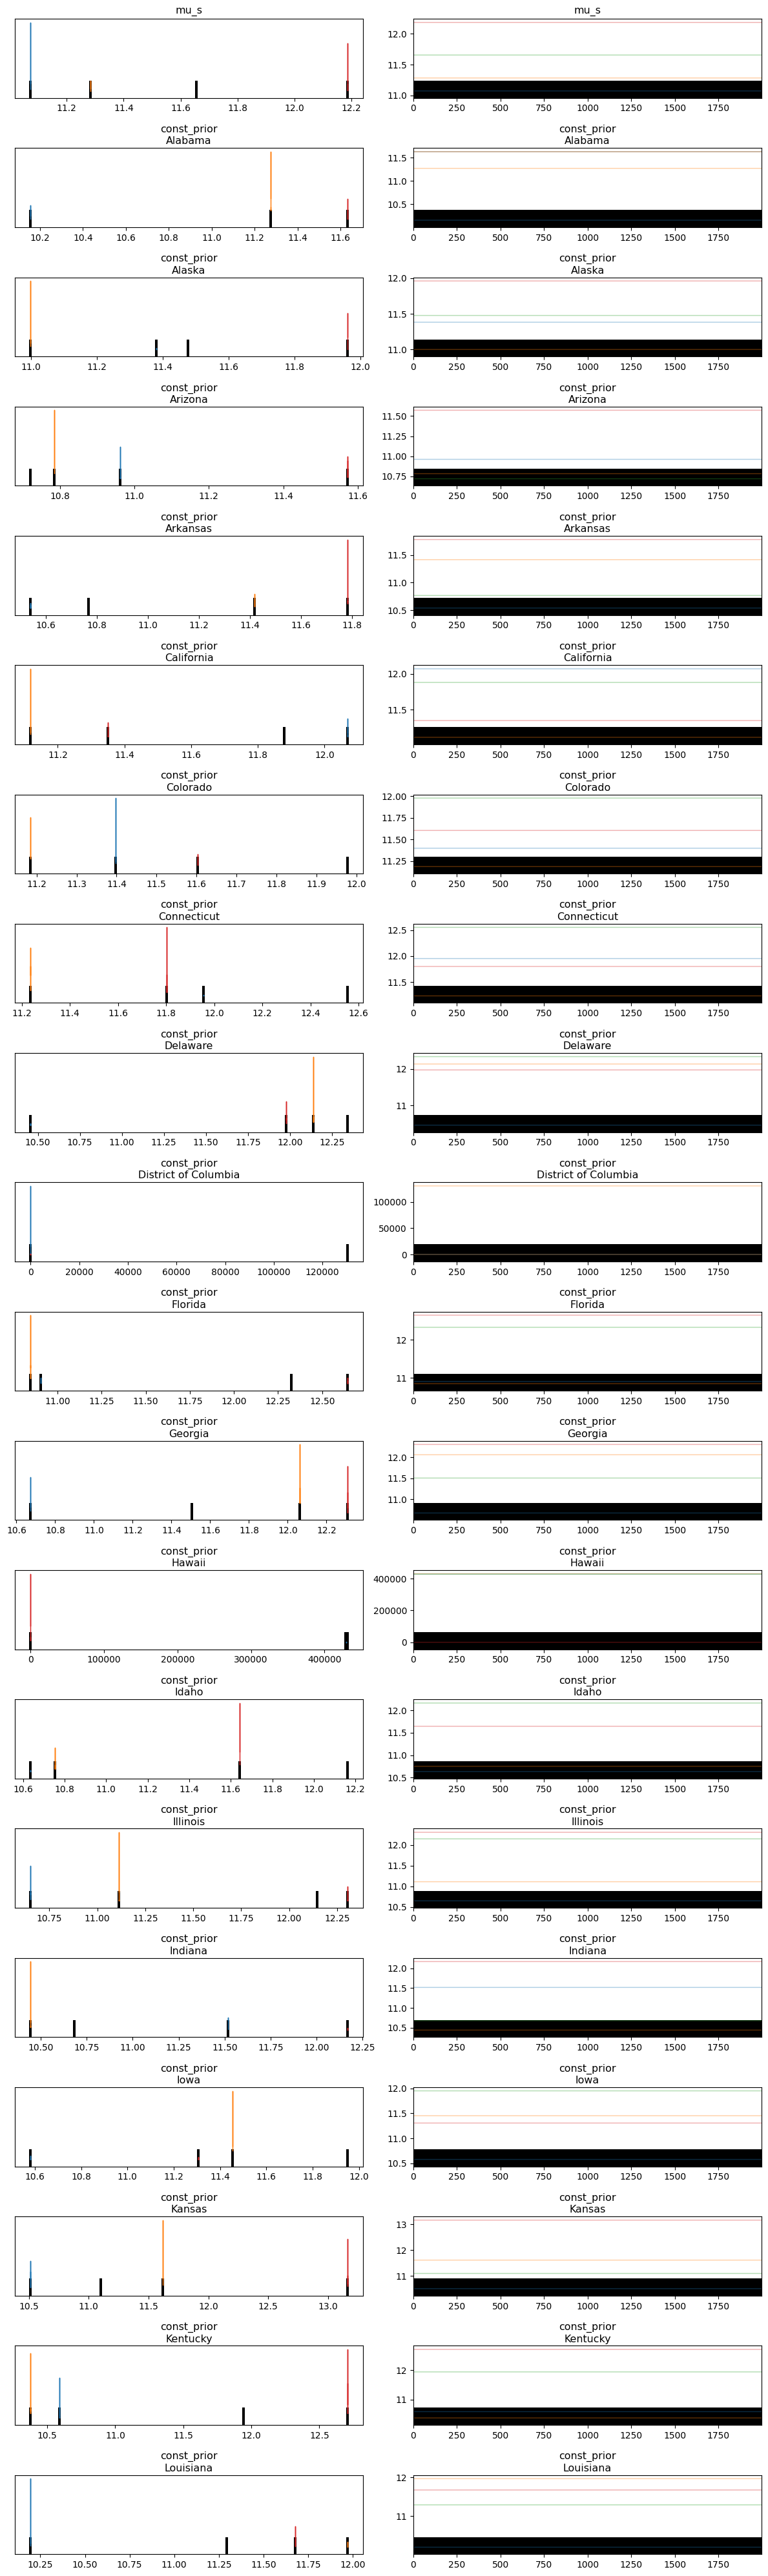

In [48]:
with model:
    az.plot_trace(trace, compact=False)
    plt.tight_layout()